In [2]:
import pandas as pd
import numpy as np
import math
import random
%matplotlib inline
import random
from matplotlib import pyplot
import os

In [3]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

In [4]:
def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=df_data.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

In [5]:
def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

In [6]:
def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

In [7]:
df = pd.read_csv('/Users/eduardorodriguez/Desktop/TFM/DATA/syndata/syndata.csv')

In [8]:
#df = df.rename(index=str, columns={"isFraud": "Class"})
df = df[:1000000]
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
df_data = df
y_true = df_data['isFraud']
df_data = df_data.drop(['nameOrig', 'nameDest','isFlaggedFraud'], axis = 1)
df_data = pd.get_dummies(df_data,prefix=['type'])
df_data = df_data.drop(['isFraud'], axis = 1)
df_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


In [10]:
sampleSize=10000
ifor=iForest(df_data.sample(100000),10,sampleSize) 

In [11]:
posLenLst=[]
negLenLst=[]

for sim in range(1000):
    ind=random.choice(df_data[y_true==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(df_data.iloc[ind],tree,0))
        
    ind=random.choice(df_data[y_true==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(df_data.iloc[ind],tree,0))

In [12]:
df = df.rename(index=str, columns={"isFraud": "Class"})
df = df.drop(['nameOrig', 'nameDest','isFlaggedFraud'], axis = 1)
df = pd.get_dummies(df,prefix=['type'])

/Users/eduardorodriguez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


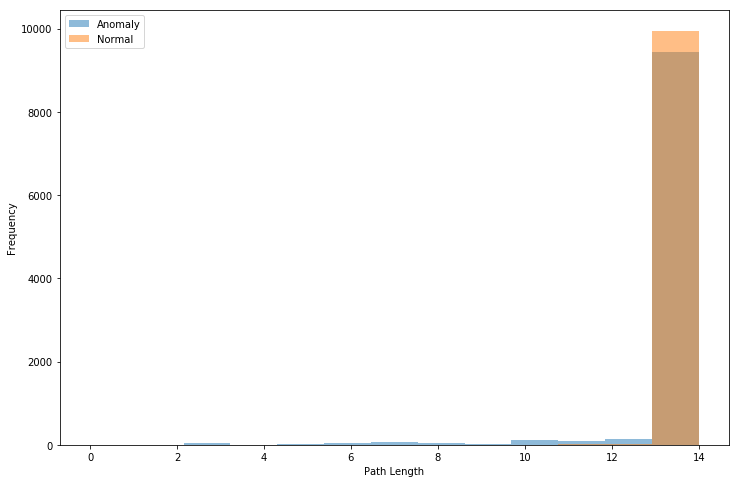

In [13]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

In [14]:
from sklearn.manifold import TSNE

In [15]:
df_plt=df[df['Class']==0].sample(1000)
df_plt_pos=df[df['Class']==1].sample(20)
df_plt=pd.concat([df_plt,df_plt_pos])
y_plt=df_plt['Class']
X_plt=df_plt.drop('Class',1)

In [16]:
X_embedded = TSNE(n_components=2).fit_transform(X_plt)

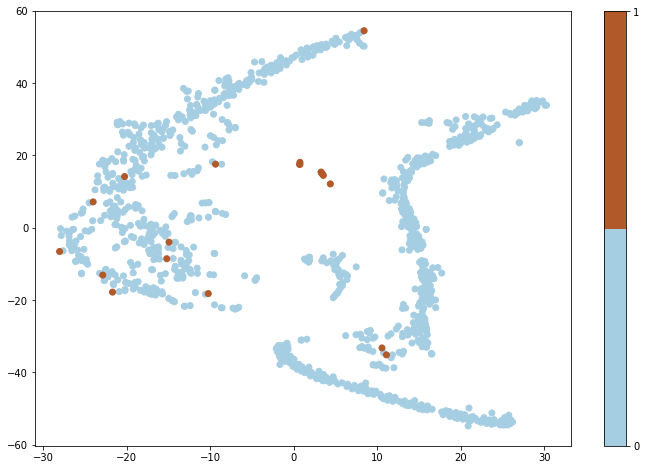

In [17]:
pyplot.figure(figsize=(12,8))
pyplot.scatter(X_embedded[:,0], X_embedded[:,1], c=y_plt, cmap=pyplot.cm.get_cmap("Paired", 2))
pyplot.colorbar(ticks=range(2))

In [18]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor ## Only available with scikit-learn 0.19 and later
from sklearn.cluster import KMeans

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_data, y_true, test_size=0.3, random_state=42)

In [21]:
## Not required for Isolation Forest
def preprocess(df_data):
    for col in df_data:
        df_data[col]=(df_data[col]-np.min(df_data[col]))/(np.max(df_data[col])-np.min(df_data[col]))
    return

In [22]:
## Not valid for LOF
def train(X,clf,ensembleSize=5,sampleSize=10000):
    mdlLst=[]
    for n in range(ensembleSize):
        X=df_data.sample(sampleSize)
        clf.fit(X)
        mdlLst.append(clf)
    
    return mdlLst

In [23]:
## Not valid for LOF
def predict(X,mdlLst):
    y_pred=np.zeros(X.shape[0])
    for clf in mdlLst:
        y_pred=np.add(y_pred,clf.decision_function(X).reshape(X.shape[0],))
    y_pred=(y_pred*1.0)/len(mdlLst)
    return y_pred

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,f1_score

In [71]:
alg=IsolationForest(n_estimators=100, max_samples='auto', contamination=0.01, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

In [72]:
%%timeit
if_mdlLst=train(X_train,alg)

1 loop, best of 3: 4.04 s per loop


In [28]:
%%timeit
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

1 loop, best of 3: 48.8 s per loop


In [29]:
if_y_pred=predict(X_test,if_mdlLst)
if_y_pred=1-if_y_pred

#Creating class labels based on decision function
if_y_pred_class=if_y_pred.copy()
if_y_pred_class[if_y_pred>=np.percentile(if_y_pred,95)]=1
if_y_pred_class[if_y_pred<np.percentile(if_y_pred,95)]=0

In [30]:
roc_auc_score(y_test, if_y_pred_class)

0.6050525262631316

In [31]:
f1_score(y_test, if_y_pred_class)

0.005148514851485148

In [32]:
if_cm=confusion_matrix(y_test, if_y_pred_class)

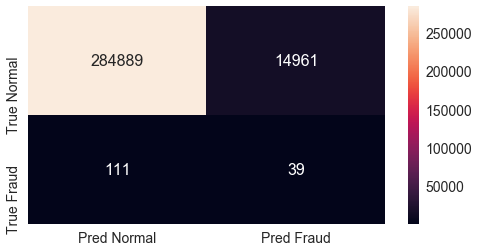

In [33]:
import seaborn as sn
     
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [34]:
%%timeit

kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

1 loop, best of 3: 16.1 s per loop


In [35]:
kmeans = KMeans(n_clusters=8, random_state=42,n_jobs=-1).fit(X_train)

In [36]:
%%timeit
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.as_matrix(),X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

/Users/eduardorodriguez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:259: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


1 loop, best of 3: 4.12 s per loop


In [37]:
X_test_clusters=kmeans.predict(X_test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(X_test.as_matrix(),X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

/Users/eduardorodriguez/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
roc_auc_score(y_test, km_y_pred)

0.5383525095881274

In [39]:
km_cm=confusion_matrix(y_test, km_y_pred)

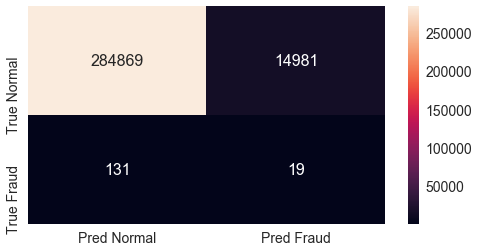

In [40]:
df_cm = pd.DataFrame(km_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [41]:
clf=LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, \
                   metric='minkowski', p=2, metric_params=None, contamination=0.1, n_jobs=-1)

In [42]:
%%timeit
clf.fit(X_test)

1 loop, best of 3: 32.2 s per loop


In [43]:
clf.fit(X_test)

LocalOutlierFactor(algorithm='auto', contamination=0.1, leaf_size=30,
          metric='minkowski', metric_params=None, n_jobs=-1,
          n_neighbors=20, p=2)

In [44]:
%%timeit
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

100 loops, best of 3: 8.51 ms per loop


In [45]:
lof_y_pred=clf.negative_outlier_factor_

#Creating class labels based on decision function
lof_y_pred_class=lof_y_pred.copy()
lof_y_pred_class[lof_y_pred>=np.percentile(lof_y_pred,95)]=1
lof_y_pred_class[lof_y_pred<np.percentile(lof_y_pred,95)]=0

In [46]:
roc_auc_score(y_test, lof_y_pred_class)

0.48499249624812407

In [47]:
lof_cm=confusion_matrix(y_test, lof_y_pred_class)

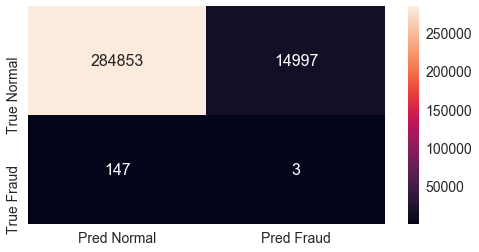

In [48]:
df_cm = pd.DataFrame(lof_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [49]:
alg=OneClassSVM(kernel='linear',gamma='auto', coef0=0.0, tol=0.001, nu=0.5, \
                shrinking=True, cache_size=200, verbose=False, max_iter=-1, random_state=42)

In [50]:
%%timeit
osvm_mdlLst=train(X_train,alg)

1 loop, best of 3: 9.91 s per loop


In [51]:
osvm_mdlLst=train(X_train,alg)

In [52]:
%%timeit
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

1 loop, best of 3: 1min 20s per loop


In [53]:
osvm_y_pred=predict(X_test,osvm_mdlLst)

#Creating class labels based on decision function
osvm_y_pred_class=osvm_y_pred.copy()
osvm_y_pred_class[osvm_y_pred<0]=1
osvm_y_pred_class[osvm_y_pred>=0]=0

In [54]:
roc_auc_score(y_test, osvm_y_pred_class)

0.5097982324495581

In [55]:
f1_score(y_test, osvm_y_pred_class)

0.0010381037305189189

In [56]:
osvm_cm=confusion_matrix(y_test, osvm_y_pred_class)

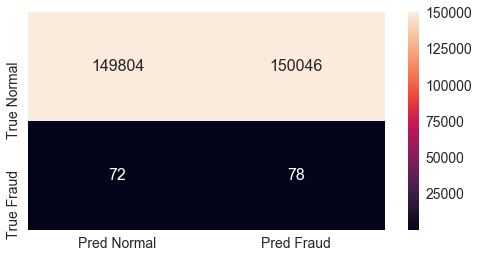

In [57]:
df_cm = pd.DataFrame(osvm_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
pyplot.figure(figsize = (8,4))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [58]:
## Performance Plot
train_times={
    'Isolation Forest': 10.5,
    'KMeans':61,
    'LOF':8.8,
    'OneClass SVM': 27.5
}

prediction_times={
    'Isolation Forest':24.3,
    'KMeans':0.934,
    'LOF':0.0088,
    'OneClass SVM': 69
}

Text(0.5,0,u'Time in seconds')

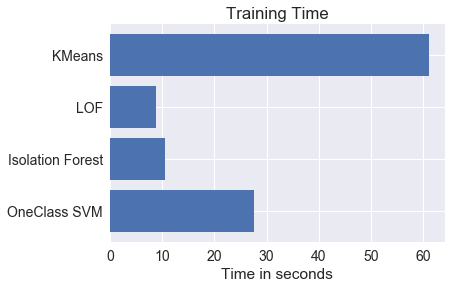

In [59]:
pyplot.title('Training Time')
pyplot.barh(range(len(train_times)), list(train_times.values()), align='center')
pyplot.yticks(range(len(train_times)), list(train_times.keys()))
pyplot.xlabel('Time in seconds')

Text(0.5,0,u'Time in seconds')

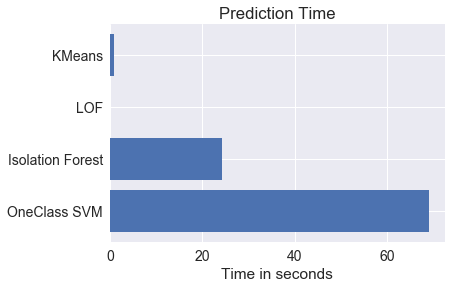

In [60]:
pyplot.title('Prediction Time')
pyplot.barh(range(len(prediction_times)), list(prediction_times.values()), align='center')
pyplot.yticks(range(len(prediction_times)), list(prediction_times.keys()))
pyplot.xlabel('Time in seconds')

In [61]:
## Performance Plot
auc_scores={
    'Isolation Forest': roc_auc_score(y_test, if_y_pred_class),
    'KMeans':roc_auc_score(y_test, km_y_pred),
    'LOF':roc_auc_score(y_test, lof_y_pred_class),
    'OneClass SVM': roc_auc_score(y_test, osvm_y_pred_class)
}

f1_scores={
    'Isolation Forest':f1_score(y_test, if_y_pred_class),
    'KMeans':f1_score(y_test, km_y_pred),
    'LOF':f1_score(y_test, lof_y_pred_class),
    'OneClass SVM': f1_score(y_test, osvm_y_pred_class)
}

Text(0.5,0,u'AUC Score')

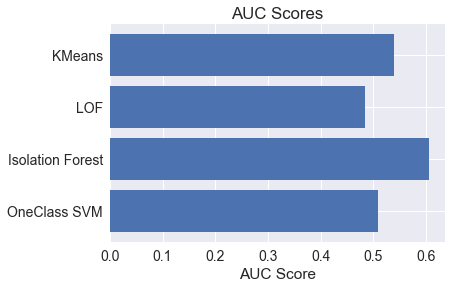

In [62]:
pyplot.title('AUC Scores')
pyplot.barh(range(len(auc_scores)), list(auc_scores.values()), align='center')
pyplot.yticks(range(len(auc_scores)), list(auc_scores.keys()))
pyplot.xlabel('AUC Score')

Text(0.5,0,u'F1 Score')

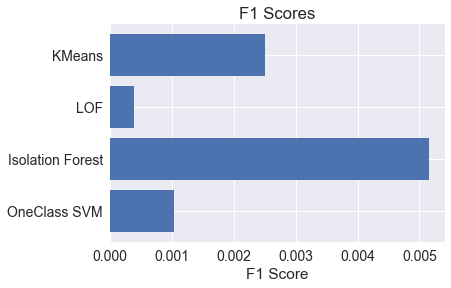

In [63]:
pyplot.title('F1 Scores')
pyplot.barh(range(len(f1_scores)), list(f1_scores.values()), align='center')
pyplot.yticks(range(len(f1_scores)), list(f1_scores.keys()))
pyplot.xlabel('F1 Score')